In [1]:
!pip install geopandas
!pip install descartes

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
#alle dataframes
df_life = pd.read_csv("./life_expectancy.csv")
df_accidents = pd.read_csv("./accidents_2017.csv")
df_accidents.rename(columns = {'Neighborhood Name':'Neighborhood', 'District Name': 'District'}, inplace = True) 
map_df = gpd.read_file('districtes.geojson').filter(items=['NOM', 'geometry'])
df_deaths = pd.read_csv("./deaths.csv")
df_transport= pd.read_csv("./transports.csv")
unemployment_df = pd.read_csv('unemployment.csv')
population_df = pd.read_csv('population.csv')
air_quality_df = pd.read_csv('datasets_71509_948751_air_quality_Nov2017.csv')
immigrants = pd.read_csv('immigrants_by_nationality.csv').groupby('District Name').count().filter(['Number']).rename(columns = {'Number':'Immigrants'})
map_df = map_df.set_index('NOM').join(immigrants)
map_df

,geometry,Immigrants
NOM,,
Ciutat Vella,"POLYGON ((2.18345 41.39061, 2.18459 41.38976, ...",1904
Eixample,"POLYGON ((2.18690 41.40165, 2.18689 41.40087, ...",2856
Sants-Montjuïc,"MULTIPOLYGON (((2.14824 41.37623, 2.14896 41.3...",3808
Les Corts,"POLYGON ((2.10342 41.40110, 2.10352 41.40109, ...",1428
Sarrià-Sant Gervasi,"MULTIPOLYGON (((2.07313 41.43522, 2.07319 41.4...",2856
Gràcia,"POLYGON ((2.13629 41.42363, 2.13640 41.42358, ...",2380
Horta-Guinardó,"POLYGON ((2.15949 41.44977, 2.15942 41.44960, ...",5236
Nou Barris,"POLYGON ((2.18706 41.46772, 2.18711 41.46711, ...",6188
Sant Andreu,"POLYGON ((2.18764 41.46212, 2.18765 41.46208, ...",3332


# Data story 1
## De leefbaarheid van de districten in Barcelona is slechter naarmate ze dichter bij de Mediterraanse zee liggen.
### Inleiding

In [4]:
unemployment_df = unemployment_df[(unemployment_df['Year'] == 2017) & (unemployment_df["Demand_occupation"] == "Registered unemployed") & (unemployment_df['Month'] == "December")]
unemployment_df = unemployment_df.groupby('District Name').sum().head(50)
unemployment_df = unemployment_df.filter(items=["Number"]).rename(columns={"Number": "unemployment"})

population = population_df.filter(['Year', 'Number', 'District.Name'])
population = population[population['Year'] == 2017].groupby('District.Name').sum().drop('Year', axis=1).rename(columns={"Number": "population"})
population = population.join(unemployment_df)
population['percentage'] = population['unemployment'] / population['population'] * 100

map_df = map_df.join(population)

Text(0.5, 1, 'Werkloosheid per district in Barcelona in 2017 as percentage van de totale populatie')

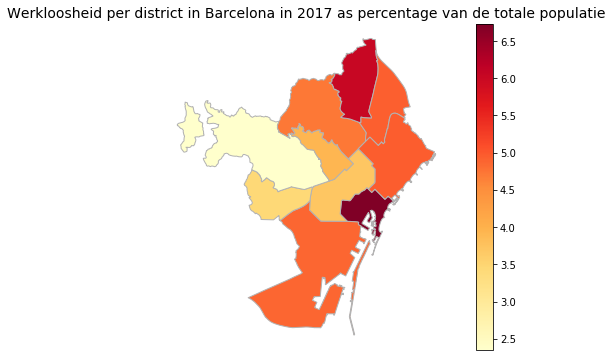

In [26]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'percentage'

# set the range for the choropleth
vmin, vmax = 0, 10

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
ax.axis('off')
map_df.plot(column='percentage', ax=ax, legend=True, cmap='YlOrRd', edgecolor='.7')
ax.set_title('Werkloosheid per district in Barcelona in 2017 as percentage van de totale populatie', fontdict={'fontsize': '14', 'fontweight' : '3'})



#### Tekst voor onder bovenstaande map

In [25]:
fig = go.Figure([go.Bar(marker_color = 'blueviolet', x=['Nou Barris', 'Gemiddelde per district'], y=[map_df['Immigrants']['Nou Barris'], map_df['Immigrants'].mean()])])

fig.update_layout(
        title ='Aantal immigranten in Nou Barris en Barcelona',
        yaxis_title = 'Aantal immigranten')
fig.show()



In [6]:
order = ['Barcelona - Ciutadella', 'Barcelona - Poblenou', 'Barcelona - Eixample', 'Barcelona - Gràcia', 'Barcelona - Palau Reial', 'Barcelona - Vall Hebron', 'Barcelona - Observ Fabra']
air_quality_df = air_quality_df.filter(['Station', 'O3 Value', 'NO2 Value', 'PM10 Value']).fillna(method='ffill')
air_quality_df = air_quality_df.groupby('Station').mean().reindex(order)

In [7]:
# Create figure
fig = go.Figure()

fig.add_trace(go.Bar(x=list(air_quality_df.index), y=list(air_quality_df['PM10 Value']),
                        name = 'PM10 waarde', marker_color = 'turquoise'))

fig.add_trace(go.Bar(x=list(air_quality_df.index), y=list(air_quality_df['NO2 Value']),
                        name = 'NO2 waarde', marker_color ='blueviolet'))

fig.add_trace(go.Bar(x=list(air_quality_df.index), y=list(air_quality_df['O3 Value']),
                        name = 'O3 waarde', marker_color = 'deeppink'))

updatemenus = list([
    dict(active=-1,
        buttons=list([
            dict(label= 'PM10 lucht waarde',
                method = 'update',
                args = [{'visible': [False, True, False]},
                       {'title' : 'PM10 lucht waarde in Barce'}]),
            dict(label = 'NO2 lucht waarde',
                method = 'update',
                args = [{'visible' : [True, False, False]},
                       {'title' : 'NO2 lucht waarde in Barcelona'}]),
            dict(label = 'O3 lucht waarde',
                method = 'update',
                args = [{'visible' : [False, False, True]},
                       {'title' : 'O3 lucht waarde in Barcelona'}]),
            dict(label = 'Alle waardes',
                method = 'update',
                args = [{'visible' : [True, True, True]},
                       {'title' : 'NO2, PM10 en O3 lucht waardes in Barcelona'}]),
        ]),
    )
])

fig.update_layout(dict(yaxis_title = 'Waarde',
                xaxis_title =  'Meetstations van Barcelona, van dichtbij tot ver van de Mediteraanse zee',
                showlegend = True,
                title = 'Waardes van NO2, PM10 en O3 in de lucht van Barcelona',
                updatemenus=updatemenus))

fig.show()

### tekst voor bovenstaande grafiek

In [46]:
#index die wordt gebruikt op basis van districen van dichtbij tot veraf van de zee
index_zee = ['Ciutat Vella', 'Sant Martí', 'Sants-Montjuïc', 'Eixample', 'Sant Andreu', 'Gràcia', 'Horta-Guinardó', 'Les Corts', 'Nou Barris', 'Sarrià-Sant Gervasi']

dis_neigh = []
for row in df_accidents.itertuples():
    district = [row.Neighborhood, row.District]
    dis_neigh.append(district)

unique_dis_neigh = [list(x) for x in set(tuple(x) for x in dis_neigh)]

# nieuwe kolomn toevoegen aan life_expectencay
df_life['district'] = [0 for i in range(len(df_life))]

for i, row in df_life.iterrows():
    for iets in unique_dis_neigh:
        if iets[0] == row['Neighborhood']:
            df_life.loc[i, 'district'] = iets[1]

df_life_update = df_life[df_life['district'] != 0]

mean_life = df_life_update.groupby('district').mean()
mean_life = mean_life.reindex(index_zee)

In [48]:
#creeer figuur op basis van life expentecy
fig = go.Figure()

for step in mean_life.columns:
    fig.add_trace(
    go.Scatter(
            visible=False,
            x= mean_life.index,
            y= mean_life[step],
            line = dict(color='deeppink')))
    
fig.data[0].visible = True

steps = []
for i in range(len(fig.data)):
    step=dict(
        method= 'update',
        label = mean_life.columns[i],
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Levensverwachting van de inwoners van districten in Barcelona in " + mean_life.columns[i]}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    yaxis_title = 'Levensverwachting in jaren',
    xaxis_tickangle=20,
    xaxis_title = 'Districten van Barcelona, van dichtbij tot ver van de Mediteraanse zee',
    title = 'Levensverwachting van de inwoners van districten in Barcelona'
)

#assen range moet nog hetzelfde blijven
fig.show()

### tekst voor bovenstaande grafiek + afsluiting

# Data story 2
## De leefbaarheid van de districten in Barcelona is beter naarmate ze dichter bij de Mediterraanse zee liggen.
### tekst voor inleiding

In [49]:
#data voor aantal doden

df_deaths_2017 = df_deaths[df_deaths['Year'] == 2017]
deaths_district = df_deaths_2017.groupby('District.Name').sum()

deaths_district = deaths_district['Number']
deaths_district = deaths_district.reindex(index_zee)

df_population = pd.read_csv("./population.csv")
df_population_2017 = df_population[df_population['Year'] == 2017]
population_district = df_population_2017.groupby('District.Name').sum()

population_district = population_district['Number']
population_district = population_district.reindex(index_zee)

deaths = deaths_district.values
population = population_district.values

#doden naar verhouding van populatie
deaths_of_population = []
for i in range(len(deaths)):
    value = (deaths[i]/population[i])*100
    deaths_of_population.append(value)  


In [51]:
#bubble chart maken
fig2 = go.Figure(data=[go.Scatter(
    x= deaths_district.index, 
    y= deaths_of_population,
    mode = 'lines + markers',
    line = dict(color='blueviolet')
)])

fig2.update_layout(
    yaxis_title = 'Aantal overledenen in verhouding tot de gehele populatie', 
    xaxis_title = 'Districten van Barcelona, van dichtbij tot ver van de Mediteraanse zee', 
    title = 'Percentage overledenen per district in Barcelona in 2017'
)

fig2.show()

### tekst voor bovenstaande grafiek + afsluiting

# Data story 2
## De leefbaarheid van de districten in Barcelona is beter naarmate ze dichter bij de Mediterraanse zee liggen.
### tekst voor inleiding

In [12]:
#data voor de bubble chart maken

df_deaths_2017 = df_deaths[df_deaths['Year'] == 2017]
deaths_district = df_deaths_2017.groupby('District.Name').sum()

deaths_district = deaths_district['Number']
deaths_district = deaths_district.reindex(index_zee)

df_population = pd.read_csv("./population.csv")
df_population_2017 = df_population[df_population['Year'] == 2017]
population_district = df_population_2017.groupby('District.Name').sum()

population_district = population_district['Number']
population_district = population_district.reindex(index_zee)

deaths = deaths_district.values
population = population_district.values

#doden naar verhouding van populatie
deaths_of_population = []
for i in range(len(deaths)):
    value = (deaths[i]/population[i])*100
    deaths_of_population.append(value)  

accidents_2017 = df_accidents.groupby('District').sum()
accidents_2017 = accidents_2017['Victims']
accidents_2017 = accidents_2017.reindex(index_zee)

accidents = accidents_2017.values

#accidents naar verhouding van populatie
accidents_of_population = []
for i in range(len(accidents_2017)):
    value = (accidents[i]/population[i])*100
    accidents_of_population.append(value)

In [13]:
districten = index_zee
df_transport = df_transport.groupby('District.Name').size()
display(df_transport)
soorten_transport = [4, 4, 7, 5, 3, 2, 2,1, 4, 2]

for district in df_transport:
    print(district)

fig4 = go.Figure([go.Bar(x=districten, y= soorten_transport, marker_color = 'turquoise', text = soorten_transport, textposition='auto')])

fig4.update_layout(
    yaxis_title = 'Aantal soorten transport',
    xaxis_title = 'Districten van Barcelona, van dichtbij tot ver van de Mediteraanse zee',
    title = 'Aantal soorten transport per district in Barcelona')

fig4.show()

District.Name
Ciutat Vella            27
Eixample               120
Gràcia                  17
Horta-Guinardó          31
Les Corts               24
Nou Barris              39
Sant Andreu             40
Sant Martí              70
Sants-Montjuïc          53
Sarrià-Sant Gervasi     66
dtype: int64

27
120
17
31
24
39
40
70
53
66


### Tekst voor bovenstaande grafiek

In [14]:
df_accidents = df_accidents[df_accidents["Neighborhood"] != "Unknown"]

df_accidents_count_serious = df_accidents.groupby(['District', 'Serious injuries']).count()
df_accidents_count_mild = df_accidents.groupby(['District', 'Mild injuries']).count()
df_accidents_count = df_accidents.groupby('District').count()
df_accidents_count = df_accidents_count.reindex(index_zee)

display(df_accidents_count_serious)

df_accidents_victims = df_accidents.groupby(['District', 'Victims']).count()
victims_district_orgineel = [634, 1645, 1316, 3562, 704, 894, 588, 839, 1290, 661]

# victims van district van dichtbij naar ver van de zee
victims_district = [634, 1645, 1316, 3562, 704, 894, 588, 839, 1290, 661]
# victims naar verhouding van alle accidents in een district
for i in range(len(victims_district)):
    victims_district[i] = (victims_district[i]/population[i])*5000
        
# serieus injuries per district van dichtbij naar ver van de zee
serious_injuries = [11, 51, 21, 60, 11, 27, 12, 10,  24, 13 ]
# serieus injuries naar verhouden van alle victims in een district
for i in range(len(serious_injuries)):
    serious_injuries[i] = (serious_injuries[i]/victims_district_orgineel[i])*100
    
# mild injuries per district van dichtbij naar ver van de zee
mild_injuries = [603, 1593, 1305, 3508, 693, 865, 576, 827, 1266, 647]
# mild injuries naar verhouden van alle victims in een district
for i in range(len(mild_injuries)):
    mild_injuries[i] = (mild_injuries[i]/victims_district_orgineel[i])*100
    

Id  Neighborhood  Street  Weekday  \
District            Serious injuries                                        
Ciutat Vella        0                  590           590     590      590   
                    1                    9             9       9        9   
                    2                    1             1       1        1   
Eixample            0                 2972          2972    2972     2972   
                    1                   54            54      54       54   
                    2                    3             3       3        3   
Gràcia              0                  520           520     520      520   
                    1                   10            10      10       10   
                    2                    1             1       1        1   
Horta-Guinardó      0                  734           734     734      734   
                    1                    8             8       8        8   
                    2                    1             1       1        1   
Les Corts           0                  704           704     704      704   
                    1                   19            19      19       19   
                    2                    2             2       2        2   
                    4                    1             1       1        1   
Nou Barris          0                  530           530     530      530   
                    1                   11            11      11       11   
                    2                    1             1       1        1   
Sant Andreu         0                  586           586     586      586   
                    1                   11            11      11       11   
Sant Martí          0                 1289          1289    1289     1289   
                    1                   43            43      43       43   
                    2                    4             4       4        4   
Sants-Montjuïc      0                 1083          1083    1083     1083   
                    1                   21            21      21       21   
Sarrià-Sant Gervasi 0                 1082          1082    1082     1082   
                    1                   20            20      20       20   
                    2                    2             2       2        2   

                                      Month   Day  Hour  Part of the day  \
District            Serious injuries                                       
Ciutat Vella        0                   590   590   590              590   
                    1                     9     9     9                9   
                    2                     1     1     1                1   
Eixample            0                  2972  2972  2972             2972   
                    1                    54    54    54               54   
                    2                     3     3     3                3   
Gràcia              0                   520   520   520              520   
                    1                    10    10    10               10   
                    2                     1     1     1                1   
Horta-Guinardó      0                   734   734   734              734   
                    1                     8     8     8                8   
                    2                     1     1     1                1   
Les Corts           0                   704   704   704              704   
                    1                    19    19    19               19   
                    2                     2     2     2                2   
                    4                     1     1     1                1   
Nou Barris          0                   530   530   530              530   
                    1                    11    11    11               11   
                    2                     1     1     1                1   
Sant Andreu         0                   586   586   586 

In [44]:
fig6= go.Figure()

fig6.add_trace(go.Scatter(y = serious_injuries, x= index_zee, 
                            mode = 'markers',
                            marker=dict(size=victims_district),
                            marker_color = 'turquoise',
                            name = 'Size = totale slachtoffers in verhouding tot populatie',
                            ))

fig6.add_trace(go.Scatter(y = mild_injuries, x= index_zee, 
                        mode = 'markers',
                        marker=dict(size=victims_district),
                        marker_color = 'deeppink',
                        name = 'Size = totale slachtoffers in verhouding tot populatie'))


updatemenus = list([
    dict(active=-1,
        buttons=list([
            dict(label= 'Milde verwondingen',
                method = 'update',
                args = [{'visible': [False, True]},
                       {'title' : 'Milde verwondingen'}]), 
            dict(label = 'Ernstige verwondingen',
                method = 'update',
                args = [{'visible' : [True, False]},
                       {'title' : 'Serious injuries'}]),
            dict(label = 'Ernstige & milde verwondingen',
                method = 'update',
                args = [{'visible' : [True, True]},
                       {'title' : 'Ernstige & milde verwondingen'}]),
        ]),
    )
])

fig6.update_layout(dict(yaxis_title = 'Percentage ernstige verwondingen van het totale aantal slachtoffers',
                xaxis_title =  { 'text' : 'Districten van Barcelona, van dichtbij tot ver van de Mediteraanse zee', 'standoff':50},
                showlegend = True,
                title = {'text' : 'Verwondingen en slachtoffers per district in Barcelona in 2017',
                            'x':0.6},
                updatemenus=updatemenus,
                legend_orientation="h",
                xaxis_tickangle=13,
                ))

fig6.show()

### tekst voor bovenstaande grafiek + afsluiting